In [15]:
import glob
import math
import pathlib

import numpy as np
from tensorflow import keras

from PIL import Image
import matplotlib.pyplot as plt

In [62]:
class CustomDataGenerator(keras.utils.Sequence):
    # We use Sequence as parent class, because Sequence are a safer way to do multiprocessing.
    # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
    
    def __init__(self, datapath, batch_size, shuffle=False, verbose=0, *args, **kwargs):
        self.batch_size = batch_size
        self.ids = [x[:-4] for x in glob.glob(f"{datapath}/*[!_labels].png")]
        self.shuffle = shuffle
        self.verbose = verbose
        #print(len(self.ids), self.ids)
        
    def __len__(self):
        # returns the number of batches
        return math.ceil(len(self.ids) / self.batch_size)
    
    def __getitem__(self, index):
        # returns one batch
        
        since = index * self.batch_size
        until = (index+1) * self.batch_size
        batch_ids = self.ids[since:until]
        
        images = []
        labels = []
        for source_id in batch_ids:
            if self.verbose > 0:
                print(source_id)
            
            x = Image.open(f"{source_id}.png")
            x = np.array(x)/255.0  # normalize between 0 and 1
            images.append(x)
            
            y = Image.open(f"{source_id}_labels.png")
            y = np.array(y)
            labels.append(y)
            
        return np.array(images), np.array(labels)
        
    def on_epoch_end(self):
        # logics run once at the very beginning and then at the end of each epoch
        if self.shuffle:
            return np.random.shuffle(self.ids) # /!\ Is this really a good idea ????

In [71]:
batch_size = 4
datapath = pathlib.Path('data','preprocessed','256x128', 'train')
datagen = CustomDataGenerator(datapath, batch_size, shuffle=True, verbose=1)
print("len:", len(datagen))

len: 744


In [72]:
datagen.on_epoch_end()
one_batch_x, one_batch_y = datagen[0]
print(one_batch_x.shape, one_batch_y.shape)

data/preprocessed/256x128/train/dusseldorf_000145_000019
data/preprocessed/256x128/train/hanover_000000_055592
data/preprocessed/256x128/train/dusseldorf_000066_000019
data/preprocessed/256x128/train/strasbourg_000001_062542
(4, 128, 256, 3) (4, 128, 256)


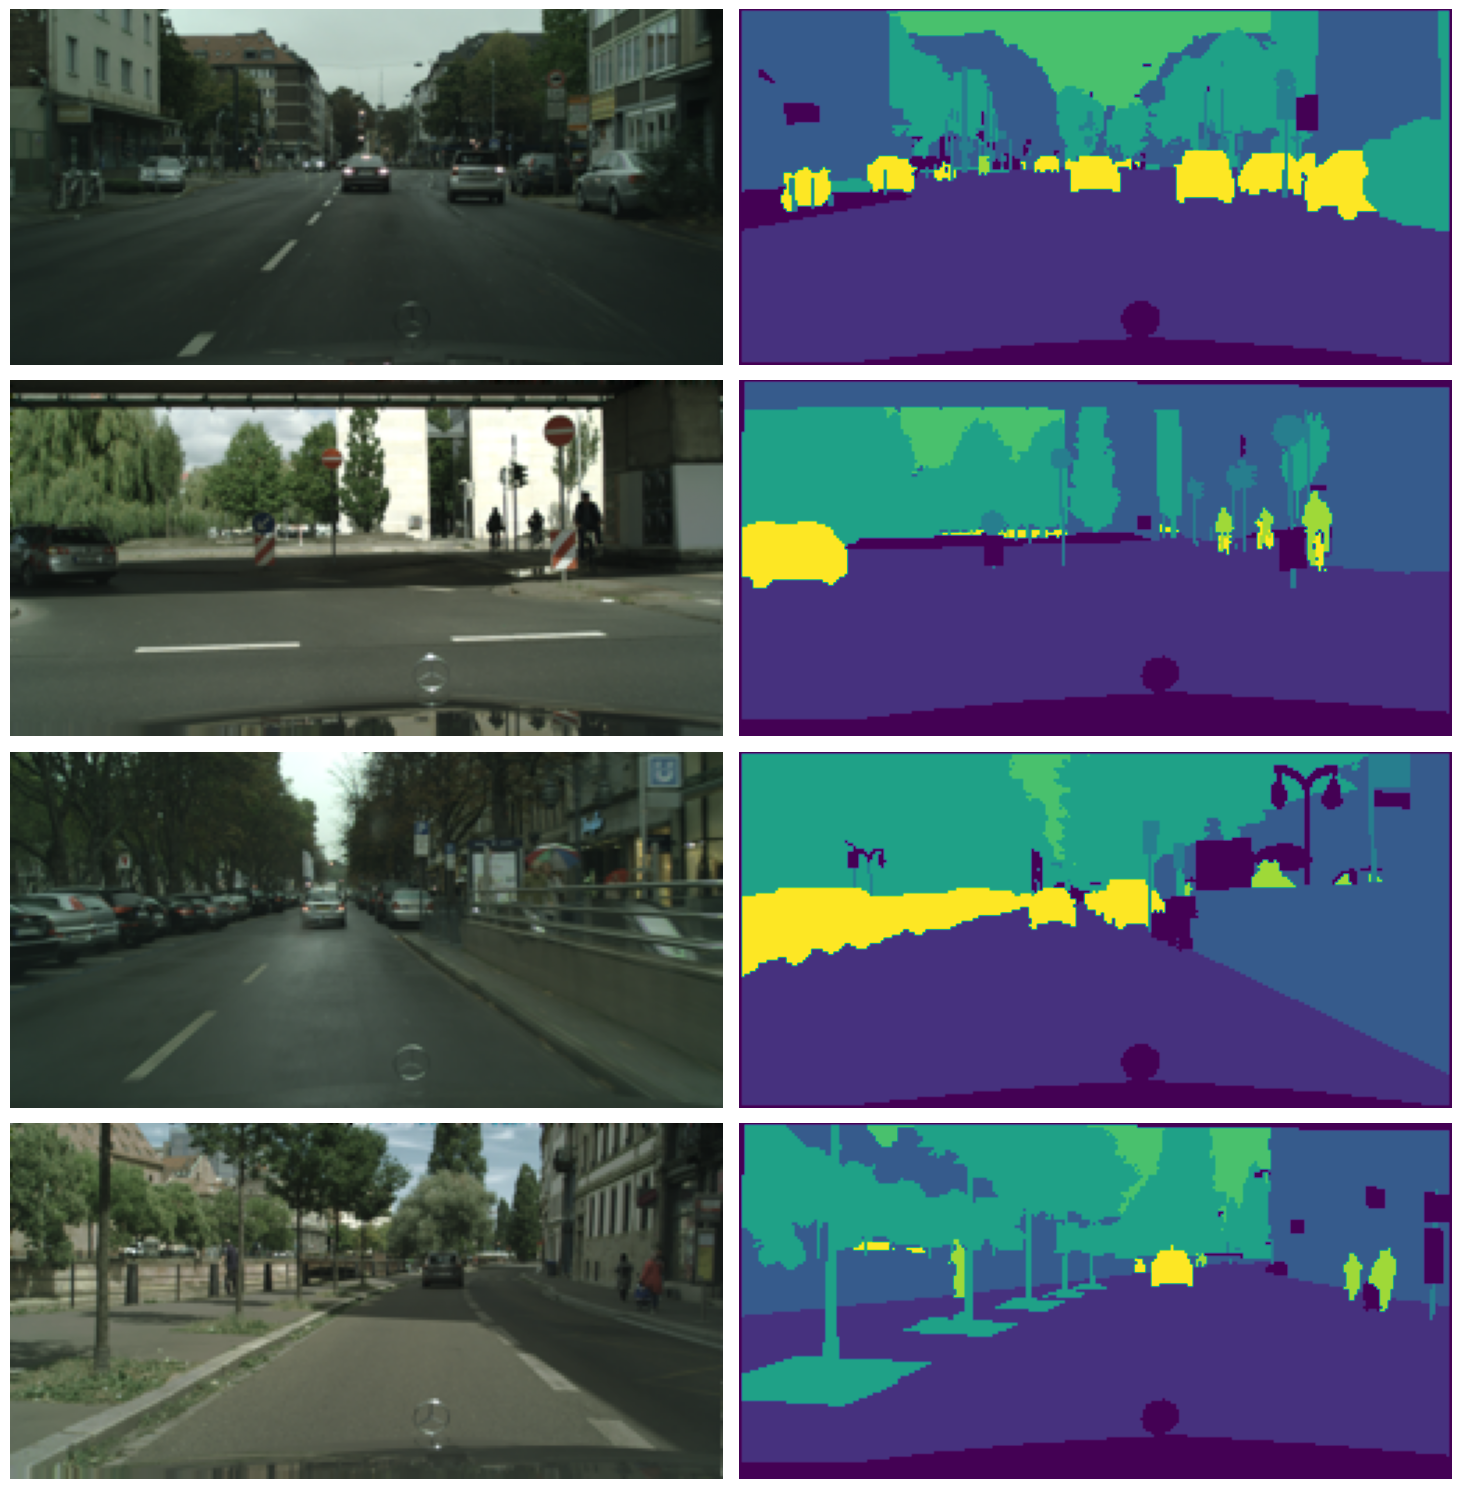

In [73]:
fig = plt.figure(figsize=(15,15))
for i, (img, mask) in enumerate(zip(one_batch_x,one_batch_y)):
    ax = plt.subplot(batch_size, 2, (i*2)+1)
    plt.imshow(img)
    ax.axis('off')
    
    ax = plt.subplot(batch_size, 2, (i*2)+2)
    plt.imshow(mask)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [5]:
STOP

NameError: name 'STOP' is not defined